Build Classification model based on features extracted

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from os import listdir
from os.path import isfile, join
import re
from matplotlib import pyplot as plt

In [2]:
def isjpg(filepath):
    return re.search(".jpg$", filepath)

In [3]:
# Function Section
def calculate_pad(brightness, saturation):
    p = 0.69*brightness + 0.22*saturation
    a = -0.31*brightness + 0.6*saturation
    d = 0.76*brightness + 0.32*saturation
    return [p,d,a]
    
def calculate_blur(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

def mean_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
    return np.mean(hsv[:,:,2])

def mean_saturation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
    return np.mean(hsv[:,:,1])

def calculate_opticalFlow(img1, img2):
    f, axarr = plt.subplots(2,1)
    axarr[0].imshow(img1)
    axarr[1].imshow(img2)
    plt.show()
    prev = cv2.cvtColor(testEld[0], cv2.COLOR_BGR2GRAY)
    forward = cv2.cvtColor(testEld[1], cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(prev)
    mask[..., 1] = 255
    flow = cv2.calcOpticalFlowFarneback(prev, forward, flow=None, pyr_scale=0.5,levels =1,winsize=3,iterations=15,poly_n=3,poly_sigma=5,flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)[0]

In [5]:
ANGER_POINT = [-0.43, 0.67, 0.34]
JOY_POINT = [0.76, 0.48, 0.35]
SURPRISE_POINT = [0.4, 0.67, -0.13]
DISGUST_POINT = [-0.6, 0.35, 0.11]
FEAR_POINT = [-0.64, 0.6, -0.43]
SADNESS_POINT = [-0.63, 0.27, -0.33]


from scipy import spatial
kdtree = spatial.cKDTree(np.array([ANGER_POINT,JOY_POINT,SURPRISE_POINT,DISGUST_POINT,FEAR_POINT,SADNESS_POINT]))

In [56]:
def label(x):
    try:
        dist, ix = kdtree.query(x,k=1)
    except Exception as e:
        print(x)
        print(e)
    if ix==0:
        return 'Anger'
    elif ix==1:
        return "Joy"
    elif ix==2:
        return 'Surprise'
    elif ix==-3:
        return "Disgust"
    elif ix==4:
        return "Fear"
    else:
        return 'Sadness'
   
    

In [6]:
import glob
import re
from scipy.interpolate import interp1d


In [61]:
modeldf=pd.read_csv('clean_df.csv')

In [73]:
tpdf=modeldf[['scene_avg_p', 'scene_avg_a','scene_avg_d','scene_avg_blur','scene_avg_optical_flow']]

In [75]:
#normallization
modeldf[['scene_avg_p', 'scene_avg_a','scene_avg_d','scene_avg_blur','scene_avg_optical_flow']]=(tpdf-tpdf.min())/(tpdf.max()-tpdf.min())

2. 3D visualization of scenes'PAD

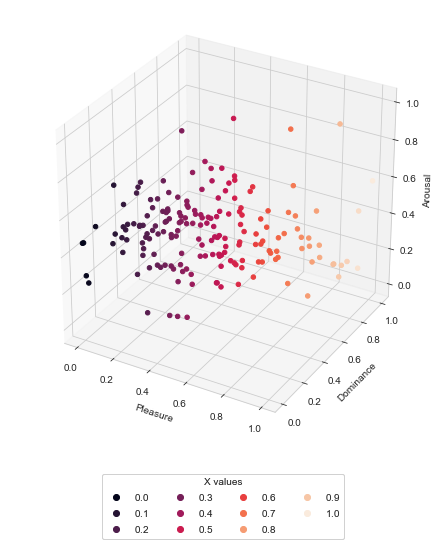

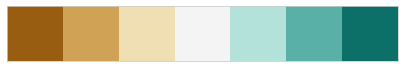

In [76]:
import seaborn as sns, numpy as np, pandas as pd, random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig)

x = modeldf['scene_avg_p'].tolist()
y = modeldf['scene_avg_d'].tolist()
z = modeldf['scene_avg_a'].tolist()

cm = sns.palplot(sns.color_palette("BrBG", 7))
g = ax.scatter(x, y, z, c=x, marker='o', depthshade=False, cmap=cm)
ax.set_xlabel('Pleasure')
ax.set_ylabel('Dominance')
ax.set_zlabel('Arousal')

# produce a legend with the unique colors from the scatter
legend = ax.legend(*g.legend_elements(), loc="lower center", title="X values", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

plt.show()

3. Other Viz

Text(0, 0.5, 'arousal')

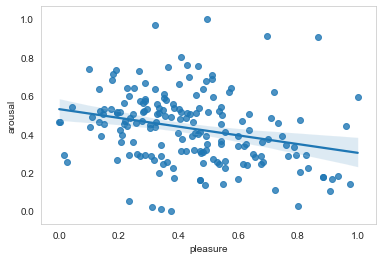

In [77]:
import seaborn as sns
sns.regplot(modeldf['scene_avg_p'],modeldf['scene_avg_a'])
plt.xlabel('pleasure')
plt.ylabel('arousal')

Text(0, 0.5, 'dominance')

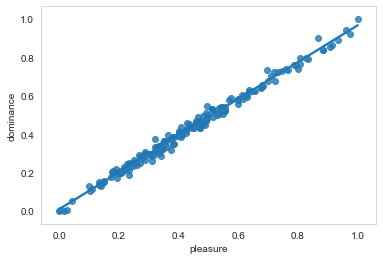

In [78]:
sns.regplot(modeldf['scene_avg_p'],modeldf['scene_avg_d'])
plt.xlabel('pleasure')
plt.ylabel('dominance')

Text(0, 0.5, 'arousal')

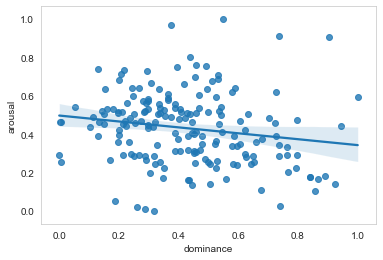

In [79]:
sns.regplot(modeldf['scene_avg_d'],modeldf['scene_avg_a'])
plt.xlabel('dominance')
plt.ylabel('arousal')

Text(0, 0.5, 'pleasure')

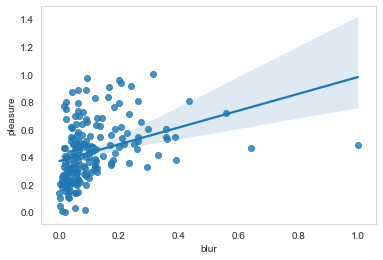

In [80]:
sns.regplot(modeldf['scene_avg_blur'],modeldf['scene_avg_p'])
plt.xlabel('blur')
plt.ylabel('pleasure')

Text(0, 0.5, 'pleasure')

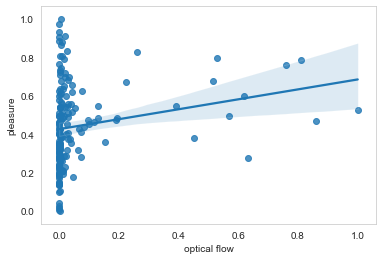

In [81]:
sns.regplot(modeldf['scene_avg_optical_flow'],modeldf['scene_avg_p'])
plt.xlabel('optical flow')
plt.ylabel('pleasure')

Text(0, 0.5, 'optical_flow')

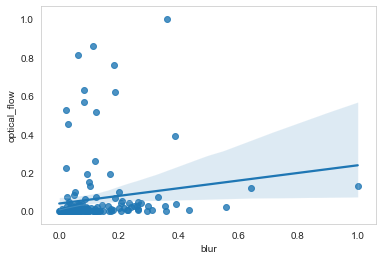

In [83]:
sns.regplot(modeldf['scene_avg_blur'],modeldf['scene_avg_optical_flow'])
plt.xlabel('blur')
plt.ylabel('optical_flow')

4. Cluster

We build 6 clusters here to classifer our emotion 

In [84]:
from sklearn.cluster import KMeans

In [85]:
numdf=modeldf[['scene_avg_p', 'scene_avg_a','scene_avg_d','scene_avg_blur','scene_avg_optical_flow']]

In [89]:
numdf=numdf.fillna(0)

In [90]:
kmeans=KMeans(n_clusters=6, random_state=0)

In [91]:
kmeans=kmeans.fit(numdf)

In [94]:
modeldf['emotion_clusters']=kmeans.labels_

Plot the 3d graph again, with clusters colors

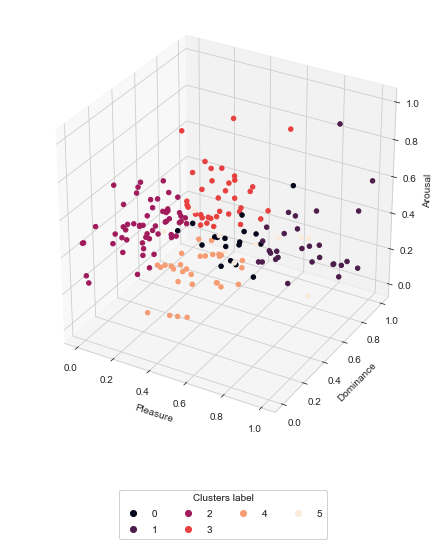

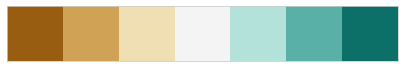

In [95]:
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig)

x = modeldf['scene_avg_p'].tolist()
y = modeldf['scene_avg_d'].tolist()
z = modeldf['scene_avg_a'].tolist()
ec=modeldf['emotion_clusters'].tolist()

cm = sns.palplot(sns.color_palette("BrBG", 7))
g = ax.scatter(x, y, z, c=ec, marker='o', depthshade=False, cmap=cm)
ax.set_xlabel('Pleasure')
ax.set_ylabel('Dominance')
ax.set_zlabel('Arousal')

# produce a legend with the unique colors from the scatter
legend = ax.legend(*g.legend_elements(), loc="lower center", title="Clusters label", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

plt.show()

This looks quite different than the PAD model only as the 6 clusters are clearly spreaded out

4. Further improvement: Dimension Reduction

1) t-SNE

In [96]:
from sklearn.manifold import TSNE

In [97]:
X_embeded=TSNE(n_components=2).fit_transform(numdf)

In [99]:
kmeans2=KMeans(n_clusters=6).fit(X_embeded)

In [105]:
dftsne=pd.DataFrame(X_embeded)

In [107]:
dftsne['emotion_clusters']=kmeans2.labels_

Text(0, 0.5, 'component 1')

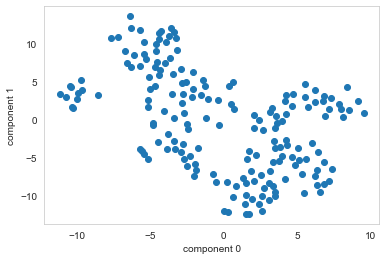

In [109]:
#two components
plt.scatter(dftsne[0], dftsne[1])
plt.xlabel('component 0')
plt.ylabel('component 1')

Text(0, 0.5, 'component 1')

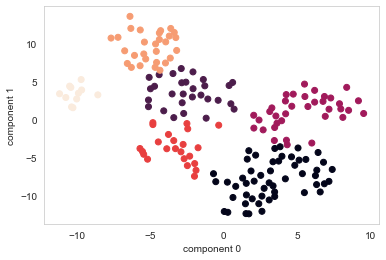

In [113]:
#6 clusters
plt.scatter(dftsne[0], dftsne[1], c=dftsne['emotion_clusters'])
plt.xlabel('component 0')
plt.ylabel('component 1')

According to TSNE vis, we can have 3 emotions instead of 6, which will be better

In [115]:
kmeans3=KMeans(n_clusters=3).fit(X_embeded)
dftsne['cluster2']=kmeans3.labels_

Text(0, 0.5, 'component 1')

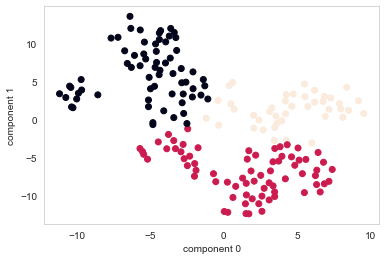

In [117]:
#3 clusters
plt.scatter(dftsne[0], dftsne[1], c=dftsne['cluster2'])
plt.xlabel('component 0')
plt.ylabel('component 1')